In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import theano.tensor as tt
#import matplotlib.pyplot as plt
import theano.tensor.slinalg as sla
from pymc3.distributions.transforms import t_stick_breaking
from pymc3 import math as pmmath
import seaborn as sns
from scipy.misc import logsumexp 
from scipy import optimize


***Use generative process to create toy data***

In [2]:
# 
L = 5
N = 1000
num_clusters = 3
num_values = 3

pi = pm.Dirichlet.dist(a=np.ones(num_clusters),shape=(num_clusters)).random()

theta_i = pm.Dirichlet.dist(a=pm.floatX((1.0 / num_values) * np.ones((num_values))),
                     shape=(num_clusters,num_values)).random()

theta_t = pm.Dirichlet.dist(a=pm.floatX((1.0 / num_values) * np.ones((num_values))),
                     shape=(num_clusters,num_values,num_values)).random()


In [3]:
data = []
clusters = []
for d in range(N):
    # draw a cluster
    cluster = np.random.choice(num_clusters,p=pi)
    #cluster = pm.Categorical.dist(pi).random(size=1)[0]
    values = []
    # draw initial value 
    prev_value = np.random.choice(num_clusters,p=theta_i[cluster])
    #prev_value = pm.Categorical.dist(theta_i[cluster]).random(size=1)[0]
    values.append(prev_value)
    for l in range(L-1):
        # draw next value based on previous value
        next_value = np.random.choice(num_clusters,p=theta_t[cluster,prev_value])
        #next_value = pm.Categorical.dist(theta_t[cluster,prev_value]).random(size=1)[0]
        values.append(prev_value)
        prev_value = next_value
    data.append(values)
    clusters.append(cluster)

In [4]:
# convert to matrix
data = np.matrix(data)
data

matrix([[2, 2, 2, 2, 2],
        [1, 1, 1, 1, 1],
        [2, 2, 0, 1, 2],
        ...,
        [1, 1, 1, 2, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 1, 2, 0]])

In [5]:
pi

array([0.13139892, 0.42825708, 0.440344  ])

In [6]:
theta_i

array([[1.80945182e-03, 5.33076445e-02, 9.44882904e-01],
       [6.46143118e-04, 5.98304538e-01, 4.01049319e-01],
       [5.34702193e-03, 4.38361895e-02, 9.50816789e-01]])

In [7]:
theta_t

array([[[0.0155648 , 0.81067493, 0.17376027],
        [0.04949375, 0.06639106, 0.88411519],
        [0.12818787, 0.01662386, 0.85518827]],

       [[0.00598692, 0.03126422, 0.96274885],
        [0.27845269, 0.71307093, 0.00847638],
        [0.05358895, 0.00104509, 0.94536597]],

       [[0.42089476, 0.47925611, 0.09984913],
        [0.00480845, 0.03374971, 0.96144184],
        [0.82045568, 0.06817766, 0.11136666]]])

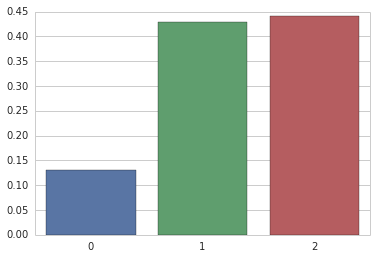

In [8]:
# plot cluster probabilities
sns.set(style="whitegrid")
sns.barplot(x=range(3),y=pi)

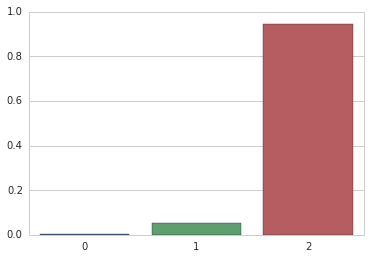

In [9]:
# initial probabilities for cluser 0
sns.barplot(x=range(num_values),y=theta_i[0])

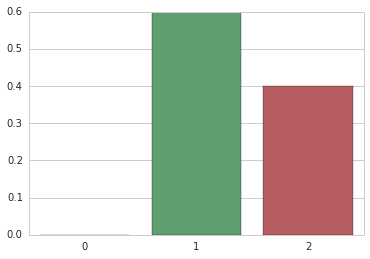

In [10]:
# initial probabilities for cluster 1
sns.barplot(x=range(num_values),y=theta_i[1])

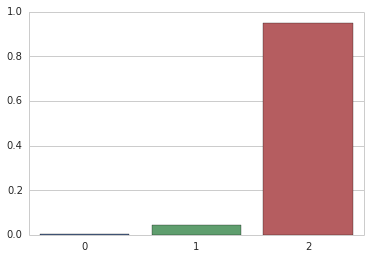

In [11]:
# initial probabilities for cluser 2
sns.barplot(x=range(num_values),y=theta_i[2])

In [12]:
# print assignments
clusters

[1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 0,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 2,
 0,
 1,
 2,
 1,
 2,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 0,
 2,
 1,
 1,
 0,
 2,
 1,
 2,
 1,
 0,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 0,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 1,
 2,
 2,
 1,


***Several tests to compare the log likelihood using regular python, numpy and theano****

In [13]:
# to compare computations wiht theano, transform data
data = data.astype("int32")
theta_i = theta_i.astype("float32")
theta_t = theta_t.astype("float32")
pi = pi.astype("float32")


# dirty way to compute likelihood of full data
l_data = []
for didx in range(len(data)):
    l_obs = []
    for pidx in range(3):
        trans = []
        for iidx in range(data[didx].shape[1]-1):
            trans.append(np.log(theta_t[pidx][data[didx,iidx],data[didx,iidx+1]]))
        l_obs.append(np.log(pi[pidx]) + np.log(theta_i[pidx][data[didx,0]]) + np.sum(trans))
    
    l_data.append(logsumexp(l_obs))
np.sum(l_data)

/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


-3631.7705

In [14]:
# same using numpy
t1 = np.log(pi)*np.ones((data.shape[0],1))
t2 = np.column_stack(np.log(theta_i[:,data[:,0]]))
t3 = np.sum(np.log(theta_t[:,data[:,:-1],data[:,1:]]),axis=2).T
l_obs  = logsumexp(t1+t2+t3,axis=1)
np.sum(l_obs)

/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  """


-3631.770334976134

In [15]:
### Same computations with theano
import theano
import theano.tensor as tt
import theano
theano.config.compute_test_value = "ignore"
theano.config.on_unused_input='ignore'

data = np.matrix(data)
tdata = tt.imatrix('tdata')
ttheta_i = tt.fmatrix('ttheta_i')
ttheta_t = tt.tensor3('ttheta_t')
tpi = tt.fvector('tpi')

# compute the full likelihood of data with theano
out = tt.sum(pmmath.logsumexp(tt.log(tpi)*tt.ones((tdata.shape[0],1))+\
                              tt.log(ttheta_i[:,tdata[:,0]]).T+\
                              tt.sum(tt.log(ttheta_t[:,tdata[:,:-1],tdata[:,1:]]),axis=2).T
                              ,axis=1))
f = theano.function([tpi,ttheta_i,ttheta_t,tdata], out)
f(pi,theta_i,theta_t,data)

array(-3631.77037666)

***Build bayesian model using pymc3***

In [16]:
class MarkovMixtureModel(pm.Categorical):
    def __init__(self, pi=None,theta_init=None,theta_trans=None,
                 *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.pi = pi
        self.theta_init = theta_init
        self.theta_trans = theta_trans
        self.mode = tt.cast(0,dtype='int64')
        self.mean = tt.cast(0,dtype='int64')

    def logp(self, docs):
        pi = self.pi
        theta_init = self.theta_init
        theta_trans = self.theta_trans
        N = docs.shape[0]
        t1 = tt.log(pi)*tt.ones((N,1))
        t2 = tt.log(theta_init[:,docs[:,0]]).T
        t3 = tt.sum(theta_trans[:,docs[:,:-1],docs[:,1:]],axis=2).T
        return tt.sum(pmmath.logsumexp(t1+t2+t3,axis=1))


In [17]:
num_clusters

3

In [18]:

with pm.Model() as model:   
    # the posterior distribution of a multinomial with a dirichlet prior is another dirichlet prior
    pi = pm.Dirichlet('pi', a=pm.floatX((1.0 / num_clusters) * np.ones(num_clusters)),
                      shape=(num_clusters),transform=t_stick_breaking(1e-9))
    theta_i = pm.Dirichlet('theta_i', a=pm.floatX((1.0 / num_values) * np.ones((num_clusters,num_values))),
                     shape=(num_clusters, num_values), transform=t_stick_breaking(1e-9))
   
    theta_t =  pm.Dirichlet('theta_t', a=pm.floatX((1.0 / num_values) * np.ones((num_clusters,num_values, num_values))),
                     shape=(num_clusters,num_values, num_values), transform=t_stick_breaking(1e-9))
    # how do we aggregate the likelihood of all the data
    #obs = pm.DensityDist('obs', log_data(pi, theta_i, theta_t), observed=data)
    obs = MarkovMixtureModel('obs',pi,theta_i,theta_t,observed=data)
    
    #start = pm.find_MAP(fmin=optimize.fmin_powell)
    #step1 = pm.Metropolis(vars=[pi,theta_i,theta_t])
    #step2 = pm.CategoricalGibbsMetropolis(vars=[obs])
    trace = pm.sample(10000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta_t_stickbreaking__, theta_i_stickbreaking__, pi_stickbreaking__]
100%|██████████| 10500/10500 [08:01<00:00, 21.80it/s]
There were 7695 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0758666317283984, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8214 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.481815388061575, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes.AxesSubplot object at 0x114d7ff10>,
      dtype=object)

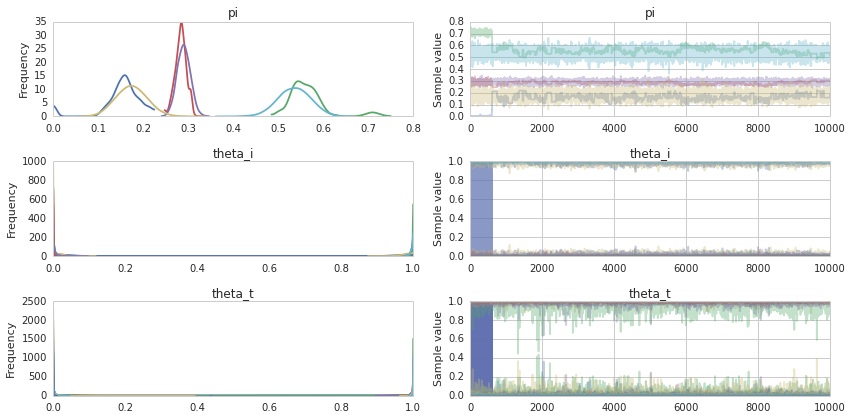

In [19]:
pm.traceplot(trace)

ValueError: object too deep for desired array

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


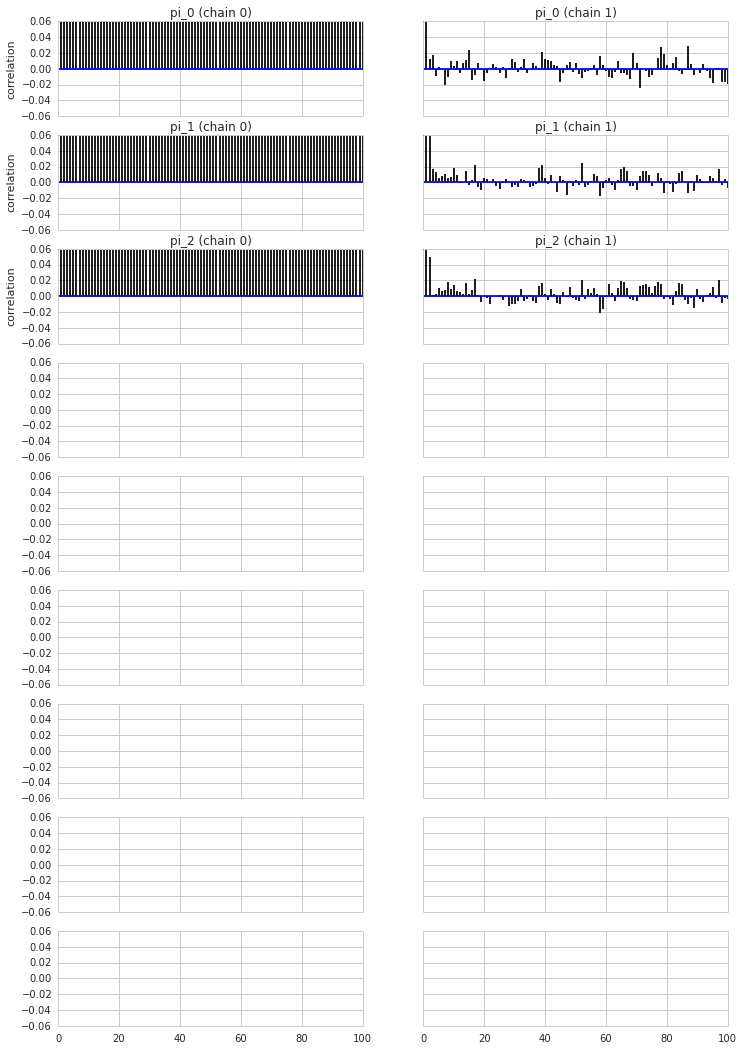

In [21]:
#### show autocorrelation of trace
pm.autocorrplot(trace)

In [22]:
trace['pi'][-1,:]

array([0.28708967, 0.2446907 , 0.46821963])

In [ ]:
trace['theta_i'][-1:]

In [ ]:
trace['theta_t'][-1:]

In [ ]:
# theanos requires to have squared data
# https://github.com/keras-team/keras/issues/40
# import keras
# preproc_seqs = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len_seq,padding='post')

# another way to variable lengths?
# https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html
#log_data(pi,theta_i,theta_t)(data)
   